In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata
from statsmodels.formula.api import ols

In [2]:
# 1. データ読み込み
df = pd.read_csv("../logs/result_20251201162005.csv")

## RSM

In [3]:
# 2. 因子を数値として扱う（RSM用）
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "PERIOD_MR", "THRESHOLD_MR"]

# 3. RSMモデル（二次回帰）
"""
formula = (
    "total ~ PERIOD_MA_1 + PERIOD_MA_2 + PERIOD_MR + THRESHOLD_MR "
    "+ I(PERIOD_MA_1**2) + I(PERIOD_MA_2**2) + I(PERIOD_MR**2) + I(THRESHOLD_MR**2) "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MR:THRESHOLD_MR"
)
"""
formula = (
    "total ~ PERIOD_MA_1 + PERIOD_MA_2 + PERIOD_MR + THRESHOLD_MR "
    "+ I(PERIOD_MA_2**2) + I(THRESHOLD_MR**2) "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MR:THRESHOLD_MR"
)
model = ols(formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     14.78
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           1.86e-17
Time:                        09:40:12   Log-Likelihood:                -1108.1
No. Observations:                 243   AIC:                             2234.
Df Residuals:                     234   BIC:                             2266.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

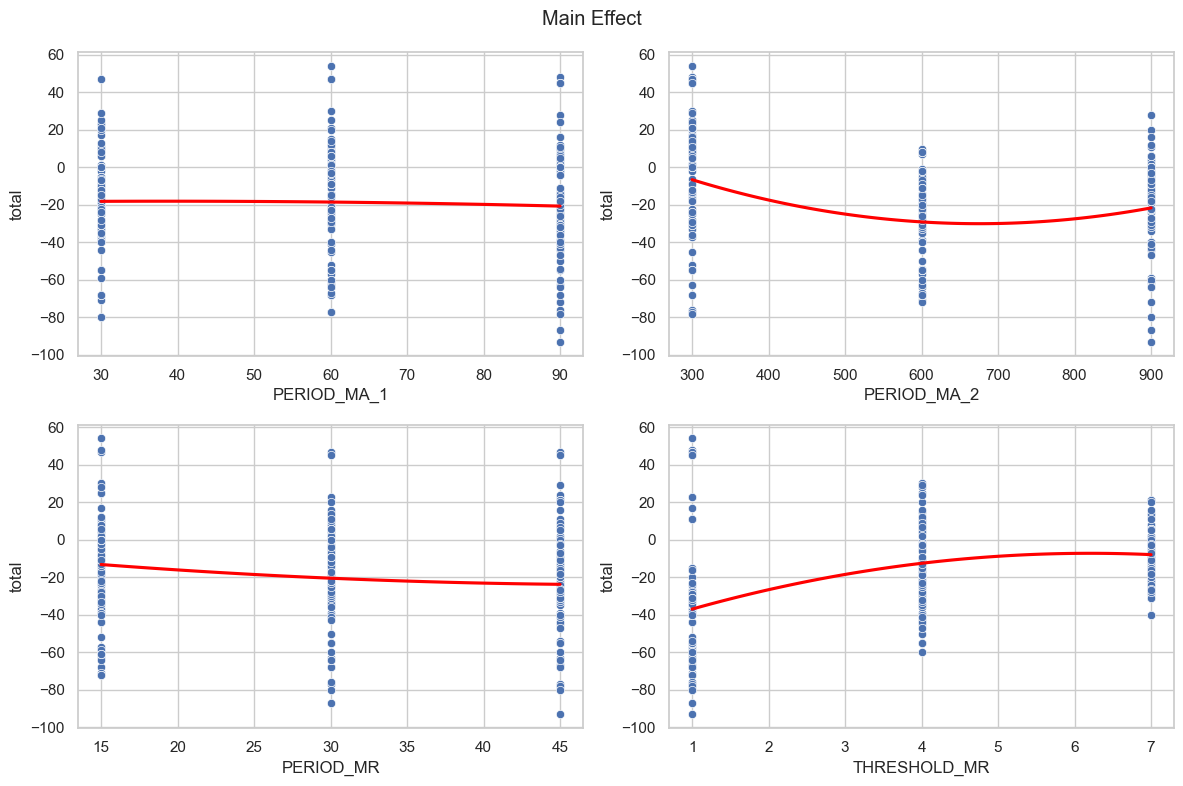

In [4]:
# 4. 可視化：散布図＋二次回帰曲線
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axes.flatten(), factor_cols):
    # 散布図
    sns.scatterplot(x=col, y="total", data=df, ax=ax)
    # 二次回帰曲線（order=2）
    sns.regplot(
        x=col, y="total", data=df, ax=ax, scatter=False, order=2, ci=None, color="red"
    )
    #ax.set_title(f"Effect of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("total")

plt.suptitle("Main Effect")
plt.tight_layout()
plt.show()

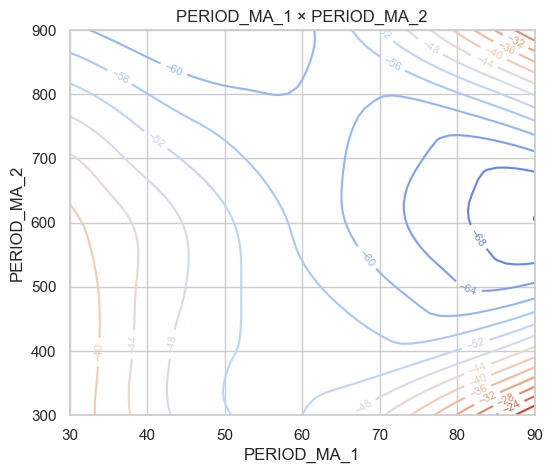

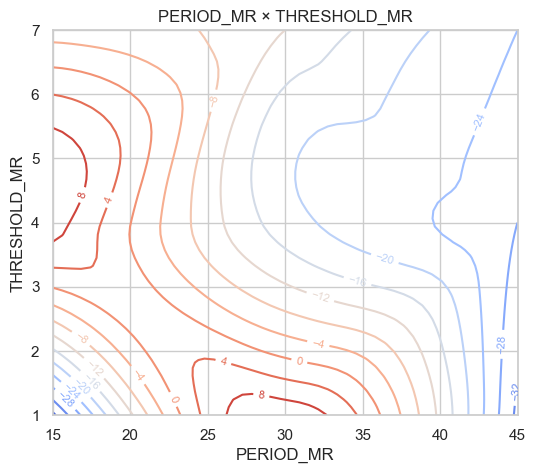

In [5]:
# データ読み込み
#df = pd.read_csv("../logs/result_20251201162005.csv")

# ===== 1. PERIOD_MA_1 × PERIOD_MA_2 =====
x = df["PERIOD_MA_1"]
y = df["PERIOD_MA_2"]
z = df["total"]

# グリッド作成
xi = np.linspace(x.min(), x.max(), 50)
yi = np.linspace(y.min(), y.max(), 50)
Xi, Yi = np.meshgrid(xi, yi)

# 補間
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

plt.figure(figsize=(6, 5))
cont = plt.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm")
plt.clabel(cont, inline=True, fontsize=8)
plt.title("PERIOD_MA_1 × PERIOD_MA_2")
plt.xlabel("PERIOD_MA_1")
plt.ylabel("PERIOD_MA_2")
plt.show()

# ===== 2. PERIOD_MR × THRESHOLD_MR =====
x = df["PERIOD_MR"]
y = df["THRESHOLD_MR"]
z = df["total"]

xi = np.linspace(x.min(), x.max(), 50)
yi = np.linspace(y.min(), y.max(), 50)
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

plt.figure(figsize=(6, 5))
cont = plt.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm")
plt.clabel(cont, inline=True, fontsize=8)
plt.title("PERIOD_MR × THRESHOLD_MR")
plt.xlabel("PERIOD_MR")
plt.ylabel("THRESHOLD_MR")
plt.show()

## RSM＋Lasso

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# 1. データ読み込み
df = pd.read_csv("../logs/result_20251201162005.csv")

# 2. 因子を数値として扱う
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "PERIOD_MR", "THRESHOLD_MR"]
X = df[factor_cols]
y = df["total"]

# 3. RSM（二次回帰）＋Lasso
poly = PolynomialFeatures(degree=2, include_bias=False)
lasso = LassoCV(cv=5, random_state=0)

model = make_pipeline(poly, lasso).fit(X, y)

# 4. サマリ統計
# 展開後の特徴量名を取得
feature_names = poly.get_feature_names_out(factor_cols)

# 係数を取り出し
coef = model.named_steps['lassocv'].coef_

# 結果をDataFrameにまとめる
summary = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
})

# 非ゼロ係数のみ表示
summary_nonzero = summary[summary["coefficient"] != 0]

print("=== Lassoによる選択結果（非ゼロ係数） ===")
print(summary_nonzero)

# モデル性能
y_pred = model.predict(X)
print("\nR^2:", r2_score(y, y_pred))
print("Best alpha (正則化パラメータ):", model.named_steps['lassocv'].alpha_)

=== Lassoによる選択結果（非ゼロ係数） ===
                     feature  coefficient
5    PERIOD_MA_1 PERIOD_MA_2    -0.000103
8              PERIOD_MA_2^2    -0.000020
9      PERIOD_MA_2 PERIOD_MR    -0.000620
10  PERIOD_MA_2 THRESHOLD_MR     0.007179

R^2: 0.256173893165923
Best alpha (正則化パラメータ): 1506.2962962962977


=== Lassoによる主効果（非ゼロ係数） ===
Empty DataFrame
Columns: [feature, coefficient]
Index: []


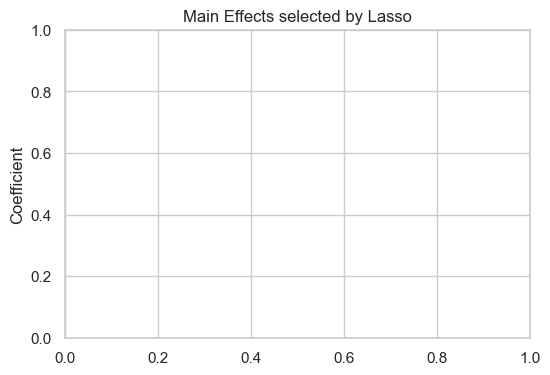

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 既存の model と poly を利用
feature_names = poly.get_feature_names_out(factor_cols)
coef = model.named_steps['lassocv'].coef_

summary = pd.DataFrame({"feature": feature_names, "coefficient": coef})

# 主効果（一次項）のみに絞る
main_effects = summary[summary["feature"].isin(factor_cols)]
main_effects_nonzero = main_effects[main_effects["coefficient"] != 0]

print("=== Lassoによる主効果（非ゼロ係数） ===")
print(main_effects_nonzero)

# 可視化：主効果の係数バー図
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.barplot(x="feature", y="coefficient", data=main_effects_nonzero, palette="coolwarm")
plt.title("Main Effects selected by Lasso")
plt.ylabel("Coefficient")
plt.show()

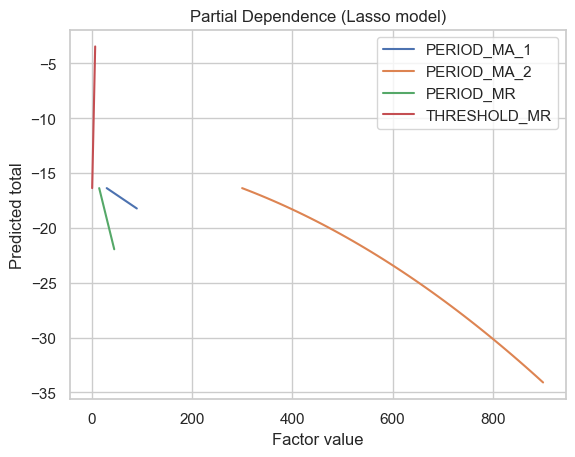

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 既存の model を利用
X = df[factor_cols]

for col in factor_cols:
    # col の範囲をグリッド化
    grid = np.linspace(X[col].min(), X[col].max(), 50)
    X_temp = X.copy()
    preds = []
    for val in grid:
        X_temp[col] = val
        preds.append(model.predict(X_temp)[0])  # 予測値
    plt.plot(grid, preds, label=col)

plt.title("Partial Dependence (Lasso model)")
plt.xlabel("Factor value")
plt.ylabel("Predicted total")
plt.legend()
plt.show()

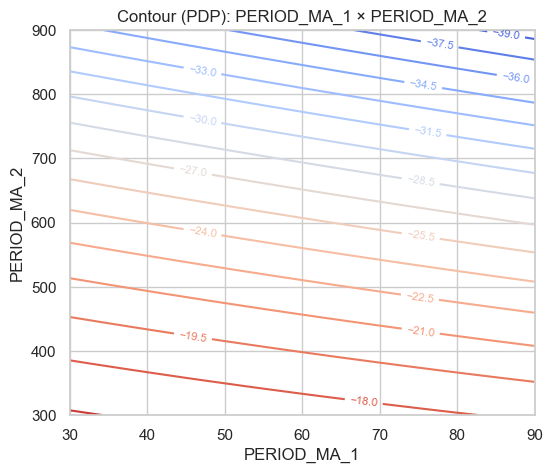

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 既存の model と X を利用
# 例: PERIOD_MA_1 × PERIOD_MA_2
x1, x2 = "PERIOD_MA_1", "PERIOD_MA_2"

# グリッド作成
xi = np.linspace(X[x1].min(), X[x1].max(), 50)
yi = np.linspace(X[x2].min(), X[x2].max(), 50)
Xi, Yi = np.meshgrid(xi, yi)

# 予測値を格納
X_temp = X.copy()
Z = np.zeros_like(Xi)

for i in range(Xi.shape[0]):
    for j in range(Xi.shape[1]):
        X_temp[x1] = Xi[i, j]
        X_temp[x2] = Yi[i, j]
        Z[i, j] = model.predict(X_temp)[0]

plt.figure(figsize=(6,5))
cont = plt.contour(Xi, Yi, Z, levels=15, cmap="coolwarm")
plt.clabel(cont, inline=True, fontsize=8)
plt.title(f"Contour (PDP): {x1} × {x2}")
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

# 同様に PERIOD_MR × THRESHOLD_MR でも描画可能

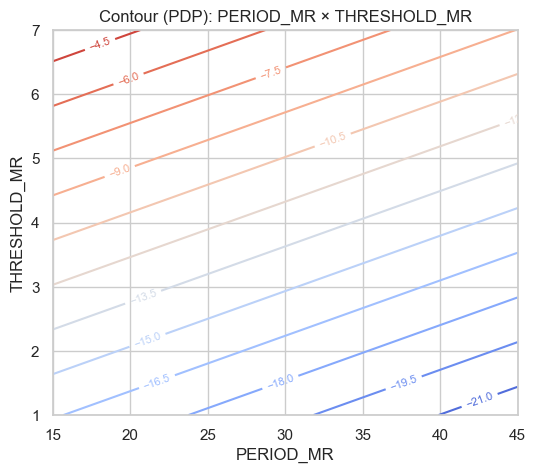

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 既存の model と X を利用
x1, x2 = "PERIOD_MR", "THRESHOLD_MR"

# グリッド作成
xi = np.linspace(X[x1].min(), X[x1].max(), 50)
yi = np.linspace(X[x2].min(), X[x2].max(), 50)
Xi, Yi = np.meshgrid(xi, yi)

# 予測値を格納
X_temp = X.copy()
Z = np.zeros_like(Xi)

for i in range(Xi.shape[0]):
    for j in range(Xi.shape[1]):
        X_temp[x1] = Xi[i, j]
        X_temp[x2] = Yi[i, j]
        Z[i, j] = model.predict(X_temp)[0]

# 等高線図（シンプルな線のみ）
plt.figure(figsize=(6,5))
cont = plt.contour(Xi, Yi, Z, levels=15, cmap="coolwarm")
plt.clabel(cont, inline=True, fontsize=8)
plt.title(f"Contour (PDP): {x1} × {x2}")
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

In [14]:
# --- RSM（二次回帰） ---
from statsmodels.formula.api import ols
import statsmodels.api as sm

formula = (
    "total ~ PERIOD_MA_1 + PERIOD_MA_2 + PERIOD_MR + THRESHOLD_MR "
    "+ I(PERIOD_MA_1**2) + I(PERIOD_MA_2**2) + I(PERIOD_MR**2) + I(THRESHOLD_MR**2) "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MR:THRESHOLD_MR"
)
model_rsm = ols(formula, data=df).fit()
print(model_rsm.summary())

# --- Lasso（二次回帰＋正則化） ---
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = df[["PERIOD_MA_1","PERIOD_MA_2","PERIOD_MR","THRESHOLD_MR"]]
y = df["total"]

poly = PolynomialFeatures(degree=2, include_bias=False)
lasso = LassoCV(cv=5, random_state=0)
model_lasso = make_pipeline(poly, lasso).fit(X, y)

print("Best alpha:", model_lasso.named_steps['lassocv'].alpha_)
print("R^2:", model_lasso.score(X, y))

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     11.79
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           2.25e-16
Time:                        09:53:26   Log-Likelihood:                -1107.9
No. Observations:                 243   AIC:                             2238.
Df Residuals:                     232   BIC:                             2276.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 